# Recipe Recommender System - Preprocessing & Modeling

## Capstone Project Three: Springboard Data Science Career Track 

### Notebook by Manthan Desai

## Introduction:

## 1. Problem Statement:

Develop a robust recipe recommender system leveraging a comprehensive dataset of recipes and a corresponding dataset of user reviews. The goal is to enhance the culinary experience for users by creating a personalized recommendation engine that suggests recipes based on individual preferences and past review history. Addressing challenges such as data integration, user profiling, and algorithmic efficiency, the system should provide accurate and diverse recommendations while accommodating users with varying dietary preferences and cultural tastes. 

## 2. The Data:

The datasets are acquired from Kaggle.com
(https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions). 

Recipe Dataset:

 - name - Recipe name
 - id - Recipe ID
 - minutes - Recipe prep time in minutes
 - contributter_id - User ID
 - submitted - Date of recipe submission
 - tags - List of keywords associated with the recipe
 - Nutrition - List of values corresponding to different nutritional elements 
 - n_steps - Number of steps
 - steps - List of the recipe steps
 - description - Recipe description
 - ingredients - Recipe ingredients
 - n_ingredients - number of ingredients
 
Users dataset:

 - user_id - Unique user ID
 - recipe_id - Recipe ID
 - date - Date of review submission
 - rating - Numeric rating between 0-5
 - review - written review of the users

## 3. Library Imports and Data Collection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

In [2]:
recipe_df = pd.read_csv('../data/recipe_data_cleaned.csv')
user_df = pd.read_csv('../data/users_data_cleaned.csv')

In [3]:
#Prepare a dataframe that merges the two dfs and preprocesses for the models
joint_df = recipe_df.merge(user_df, left_on='id', right_on='recipe_id')
joint_df.drop(['recipe_id'], axis=1, inplace=True)
joint_df['Prep Time'] = joint_df['Prep Time'].map({'Short': 0, 'Medium': 1, 'Long': 2})
joint_df['Ingredient List'] = joint_df['Ingredient List'].map({'Short': 0, 'Medium': 1, 'Long': 2})
joint_df['Recipe Process'] = joint_df['Recipe Process'].map({'Short': 0, 'Medium': 1, 'Long': 2})
joint_df['cuisine'] = joint_df['cuisine'].map({'north american': 0, 'asian': 1, 'european': 2, 'african': 3, 'south american': 4, 'australian': 5, np.nan: -1})
joint_df.head()

,id,name,minutes,n_steps,n_ingredients,Prep Time,Ingredient List,Recipe Process,is_vegan,is_vegetarian,...,nutrition_1,nutrition_2,nutrition_3,nutrition_4,nutrition_5,nutrition_6,nutrition_7,user_id,date,rating
0,137739,arriba baked winter squash mexican style,55,11,7,0,0,0,0,1,...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,4470,2006-02-18,5
1,137739,arriba baked winter squash mexican style,55,11,7,0,0,0,0,1,...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,593927,2010-08-21,5
2,137739,arriba baked winter squash mexican style,55,11,7,0,0,0,0,1,...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,178427,2011-12-05,5
3,31490,a bit different breakfast pizza,30,9,6,0,0,0,0,0,...,173.4,18.0,0.0,17.0,22.0,35.0,1.0,28603,2002-08-19,0
4,31490,a bit different breakfast pizza,30,9,6,0,0,0,0,0,...,173.4,18.0,0.0,17.0,22.0,35.0,1.0,346277,2006-08-27,5


## 4. Simple Recommender System

This simple recommender system determines and returns the top n recipes as rated by all users 

In [4]:
def top_recommendations(num_recommendations):
    #prepare a df for SR system
    grouped_ratings = user_df.groupby('recipe_id', as_index=False)['rating'].mean().rename(columns= {'rating':'mean_rating'})
    grouped_votecount = user_df.groupby('recipe_id', as_index=False)['rating'].count().rename(columns= {'rating':'rating_count'})
    gr_df = grouped_ratings.merge(grouped_votecount, on='recipe_id')
    ratings_df = recipe_df.merge(gr_df, left_on='id', right_on='recipe_id')
    ratings_df.drop('recipe_id', axis=1, inplace=True)
    
    #determine and apply a threshold to filter recipes by the number of reviews
    C = ratings_df['mean_rating'].mean()
    m = ratings_df['rating_count'].quantile(0.90)
    filtered_ratings = ratings_df.copy().loc[ratings_df['rating_count']>=m]
    
    # Calculate a weighted score based on the IMDB weighted rating formula
    def weighted_rating(x, m=m, C=C):
        v = x['rating_count']
        R = x['mean_rating']
        return (v/(v+m) * R) + (m/(m+v) * C)
    
    #return recommendations based on the highest scores
    filtered_ratings['score'] = filtered_ratings.apply(weighted_rating, axis=1)
    filtered_ratings.sort_values('score', ascending=False, inplace=True)
    filtered_ratings.set_index('id')
    return filtered_ratings[['name','score','rating_count']].head(num_recommendations)

In [5]:
top_recommendations(5).rename({'name': 'Recipe Name', 'score': 'Weighted Rating', 'rating_count': 'Number of Ratings'}, axis=1)

,Recipe Name,Weighted Rating,Number of Ratings
134684,mexican stack up rsc,4.965116,217
35255,caprese salad tomatoes italian marinated toma...,4.903545,52
129662,mango salsa 1,4.892966,74
207459,syrup for blueberry pancakes,4.880549,57
214172,toffee dip with apples,4.876816,55


## 5. Content Based Recommender

This content-based recommender system aims to find the top-n most similar recipes to the recipe passed in as input. Cosine similarity is a good measure for finding most similar items however it is not a space efficient option. For a large dataset, it requires unrealistic amount of memory hence a better alternative for optimizing memory constraints is k-means which approximates the similarity between each data points through clusters.

In [6]:
df = recipe_df.set_index('id')
df['Prep Time'] = df['Prep Time'].map({'Short': 0, 'Medium': 1, 'Long': 2})
df['Ingredient List'] = df['Ingredient List'].map({'Short': 0, 'Medium': 1, 'Long': 2})
df['Recipe Process'] = df['Recipe Process'].map({'Short': 0, 'Medium': 1, 'Long': 2})
df['cuisine'] = df['cuisine'].map({'north american': 0, 'asian': 1, 'european': 2, 'african': 3, 'south american': 4, 'australian': 5})
df.dropna(axis=0,inplace=True)

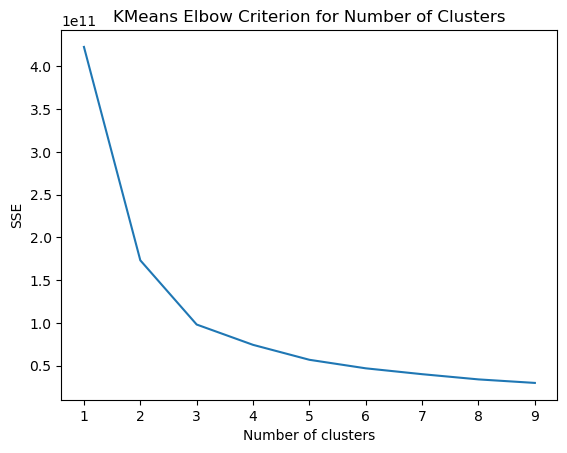

In [7]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(df.drop('name',axis=1))
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title('KMeans Elbow Criterion for Number of Clusters')
plt.show()

From the elbow curve, we find that the ideal number of clusters is between 3-5.

In [8]:
kmeans = KMeans(n_clusters=4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(df.drop('name', axis=1))
X_dist = kmeans.transform(df.drop('name',axis=1))**2
labels = kmeans.labels_

In [9]:
recipes_cluster = pd.DataFrame(np.concatenate((df.reset_index()['id'].values.reshape(-1,1), labels.reshape(-1,1)), axis = 1), columns = ['recipeId', 'cluster'])
recipes_cluster['dist_to_closest_centroid'] = X_dist.min(axis=1)
recipes_cluster.T

,0,1,2,3,4,5,6,7,8,9,...,90050,90051,90052,90053,90054,90055,90056,90057,90058,90059
recipeId,137739.000000,31490.000000,44061.000000,5289.000000,25274.000000,67888.000000,6.754700e+04,43026.000000,8559.000000,23850.000000,...,27846.000000,60148.000000,424875.000000,86005.000000,103312.000000,455209.000000,61748.000000,410985.000000,357451.000000,486161.000000
cluster,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
dist_to_closest_centroid,131915.111795,60630.410366,97212.000773,70528.115363,10262.796129,674045.470966,8.309568e+06,103133.704947,1912.266482,57413.551621,...,39747.902279,85529.505498,80127.889163,60235.172918,228572.585248,94632.328562,28718.727149,12211.964105,36107.993254,2089.294924


In [10]:
def get_recommendations(recipe_id, num_recommendations):
    rc = recipes_cluster.loc[recipes_cluster['recipeId']==recipe_id]['cluster']
    sorted_cluster_recipes = recipes_cluster.loc[recipes_cluster['cluster']==int(rc)].sort_values('dist_to_closest_centroid', ascending=True)
    idx = sorted_cluster_recipes.loc[recipes_cluster['recipeId']!=recipe_id]['recipeId'][:num_recommendations]
    return df.loc[df.index.isin(idx)]['name']

In [11]:
get_recommendations(144117, 5)

id
503239                   baked beans with baked bacon
35418     beef stuffed bell peppers with creole sauce
349048                               enchiladas verde
33431                                        meatloaf
426424                     spicy lamb stuffed peppers
Name: name, dtype: object

## 6. Hybrid Recommender System

In [12]:
review_counts = pd.DataFrame(joint_df['id'].value_counts())
rare_recipes = review_counts[review_counts['id'] <= 40].index
common_recipes = joint_df[~joint_df['id'].isin(rare_recipes)]
user_recipe_df = common_recipes.pivot_table(index=['user_id'], columns=['id'], values='rating')

In [13]:
def hybrid_recommendations(user_id, num_recommendations):
    #reduce the dataset to the user and choose all non-null recipes
    random_user_df = user_recipe_df[user_recipe_df.index == user_id]
    recipes_viewed = random_user_df.columns[random_user_df.notna().any()].tolist()
    recipes_viewed_df = user_recipe_df[recipes_viewed]
    
    #dataset of how many recipes, from the list of recipes viewed by input user, each user viewed in total:
    user_recipe_count = recipes_viewed_df.T.notnull().sum()
    user_recipe_count = user_recipe_count.reset_index()
    user_recipe_count.columns = ["userId","recipe_count"]
    
    #users who have viewed atleast 25% of the same recipes as the input user
    perc = len(recipes_viewed) * 25 / 100
    users_same_recipes = user_recipe_count[user_recipe_count['recipe_count'] > perc]['userId']
    
    #combine the data of the input user and similar users and calculate the correlation
    final_df = pd.concat([recipes_viewed_df[recipes_viewed_df.index.isin(users_same_recipes)],random_user_df[recipes_viewed]])
    corr_df = final_df.T.corr().unstack().sort_values().drop_duplicates()
    corr_df = pd.DataFrame(corr_df, columns=["corr"])
    corr_df.index.names = ['user_id_1', 'user_id_2']
    corr_df = corr_df.reset_index()
    
    #top user correlations with the input user (top defined to be greater or equal to the mean correlation)
    mean_corr = corr_df['corr'].mean()
    top_users = corr_df[(corr_df["user_id_1"] == user_id) & (corr_df["corr"] >= mean_corr)][["user_id_2", "corr"]].reset_index(drop=True)
    top_users = top_users.sort_values(by='corr', ascending=False)
    top_users.rename(columns={"user_id_2": "userId"}, inplace=True)
    
    #if no correlated users found
    if((top_users.empty) or len(top_users) == 1):
        return top_recommendations(5)
        
    #The list of top users with the correlation joined with their recipe ratings
    top_user_ratings = top_users.merge(user_df[['user_id', 'recipe_id', 'rating']], how='inner', left_on='userId', right_on='user_id')
    top_user_ratings = top_user_ratings[top_user_ratings["userId"] != user_id]
    top_user_ratings.drop('user_id',axis=1, inplace=True)
    
    #Calculate weighted rating by multiplying the correlation with the user rating
    top_user_ratings['weighted_rating'] = top_user_ratings['corr'] * top_user_ratings['rating']
    recommendation_df = top_user_ratings.groupby('recipe_id').agg({"weighted_rating": "mean"})
    recommendation_df = recommendation_df.reset_index()
    
    recipes_to_recommend = recommendation_df[recommendation_df["weighted_rating"] >= 3.0].sort_values("weighted_rating", ascending=False)
    return recipes_to_recommend.merge(recipe_df[['id','name']], how='inner', left_on='recipe_id', right_on='id').drop('id', axis=1)[:num_recommendations].set_index('recipe_id')

In [14]:
hybrid_recommendations(28603, 5)

,weighted_rating,name
recipe_id,,
2625,5.0,spinach cashew salad
175343,5.0,banana spice bars
168748,5.0,rachael ray s mamacello pasta
167894,5.0,boneless pork chops milanese
167792,5.0,honey glazed corned beef


## 7. Putting it all together

A full recommendation engine accounts for multiple scenarios such as a user with many reviews and a user with no reviews. The engine belows considers three scenarios and utilizes all three recommenders constructed above.

In [15]:
def recommend(user_id, num_recommendations):
    num_ratings_by_user = joint_df[joint_df['user_id'] == user_id]['rating'].count()
    
    #Scenario 1: Brand new user then recommend the most popular recipes
    if(num_ratings_by_user == 0):
        return top_recommendations(num_recommendations).rename({'name': 'Recipe Name', 'score': 'Weighted Rating', 'rating_count': 'Number of Ratings'}, axis=1)
    #Scenario 2: Only 1 review by the user then use the content recommender
    elif(num_ratings_by_user == 1):
        recipe_id = joint_df[joint_df['user_id'] == user_id]['id']
        return get_recommendations(recipe_id, num_recommendations)
    #Scenario 3: Multiple ratings by the user, then use the hybrid recommender
    else:
        return hybrid_recommendations(user_id, num_recommendations)

In [16]:
recommend(10,5)

,Recipe Name,Weighted Rating,Number of Ratings
134684,mexican stack up rsc,4.965116,217
35255,caprese salad tomatoes italian marinated toma...,4.903545,52
129662,mango salsa 1,4.892966,74
207459,syrup for blueberry pancakes,4.880549,57
214172,toffee dip with apples,4.876816,55


## 8. Evaluating Model Performance

The datasets contain no ground truth which can be compared against the predicted values to evaluate performance. Furthermore, unlike commercial recommender systems, users can't provide real time feedback on their recommendations which cand be used to evaluate performance. Therefore, performance must be evaluated in an unorthodox manner.

In [17]:
perf_df = recipe_df.set_index('id')
perf_df['Prep Time'] = perf_df['Prep Time'].map({'Short': 0, 'Medium': 1, 'Long': 2})
perf_df['Ingredient List'] = perf_df['Ingredient List'].map({'Short': 0, 'Medium': 1, 'Long': 2})
perf_df['Recipe Process'] = perf_df['Recipe Process'].map({'Short': 0, 'Medium': 1, 'Long': 2})
perf_df['cuisine'] = perf_df['cuisine'].map({'north american': 0, 'asian': 1, 'european': 2, 'african': 3, 'south american': 4, 'australian': 5})
perf_df.fillna(-1,inplace=True)
perf_df.head()

,name,minutes,n_steps,n_ingredients,Prep Time,Ingredient List,Recipe Process,is_vegan,is_vegetarian,cuisine,nutrition_1,nutrition_2,nutrition_3,nutrition_4,nutrition_5,nutrition_6,nutrition_7
id,,,,,,,,,,,,,,,,,
137739,arriba baked winter squash mexican style,55,11,7,0,0,0,0,1,0.0,51.5,0.0,13.0,0.0,2.0,0.0,4.0
31490,a bit different breakfast pizza,30,9,6,0,0,0,0,0,0.0,173.4,18.0,0.0,17.0,22.0,35.0,1.0
112140,all in the kitchen chili,130,6,13,2,2,2,0,0,-1.0,269.8,22.0,32.0,48.0,39.0,27.0,5.0
59389,alouette potatoes,45,11,11,0,0,0,0,0,-1.0,368.1,17.0,10.0,2.0,14.0,8.0,20.0
44061,amish tomato ketchup for canning,190,5,8,2,2,2,0,1,0.0,352.9,1.0,337.0,23.0,3.0,0.0,28.0


#### Cosine similarity as a performance metric

Cosine similarity can be tested as a viable performance metric by checking how it performs on two closely related recipes and two unrelated recipes. 

In [18]:
related_recipe_1 = perf_df[perf_df.index==298512]
related_recipe_2 = perf_df[perf_df.index==298509]
print(related_recipe_1['name'])
print(related_recipe_2['name'])
print('cosine similarity of the related recipes:',cosine_similarity(related_recipe_1.drop('name', axis=1),related_recipe_2.drop('name', axis=1)))

id
298512    cookies by design   cookies on a stick
Name: name, dtype: object
id
298509    cookies by design   sugar shortbread cookies
Name: name, dtype: object
cosine similarity of the related recipes: [[0.99170411]]


In [19]:
unrelated_recipe_1 = perf_df[perf_df.index==486161]
unrelated_recipe_2 = perf_df[perf_df.index==298509]
print(unrelated_recipe_1['name'])
print(unrelated_recipe_2['name'])
print('cosine similarity of the unrelated recipes:',cosine_similarity(unrelated_recipe_1.drop('name', axis=1),unrelated_recipe_2.drop('name', axis=1)))

id
486161    zydeco soup
Name: name, dtype: object
id
298509    cookies by design   sugar shortbread cookies
Name: name, dtype: object
cosine similarity of the unrelated recipes: [[0.9898112]]


As seen above, the cosine similarity shows a high degree of similarity between the two related recipes however it also shows a fairly high similarity between two unrelated recipes. This result makes cosine similarity an unreliable metric to evaluate performance.

#### Manual performance evaluation

In lieu of an established performance metric that can be used for this particular case, the model's performance needs to be evaluated manually. I do so by randomly sampling 20 users from the dataset and extracting their most recent recipe reviewed. I manually compare this recipe against the hybrid recommendations generated based on that user's entire review history to determine whether the recommendations are relevant or not.

Comparision criteria: Cuisine type and food type (appetizer, entree, dessert, etc)

In [20]:
random.seed(100)
users_with_many_reviews = common_recipes.groupby("user_id").filter(lambda x: len(x) > 5)
random_userids = random.sample(list(users_with_many_reviews['user_id'].unique()), 20)
random_sample_df = common_recipes[common_recipes['user_id'].isin(random_userids)]
random_sample_df = random_sample_df.groupby('user_id',as_index=False).apply(lambda x: x[x['date'] == x['date'].max()])

In [21]:
def evaluate_model_performance(id_list):    
    recipes_list = []
    for uid in id_list:
        recipes = []
        all_recipeids = random_sample_df[random_sample_df['user_id'] == uid]['id']
        already_viewed = perf_df[perf_df.index.isin(all_recipeids)]
        recipes.append(already_viewed['name'].values)
        reco_recipes = perf_df[perf_df.index.isin(hybrid_recommendations(uid, 5).index)]
        recipes.append(reco_recipes['name'].values)
        recipes_list.append(recipes)
    return recipes_list

In [22]:
recipe_recs = evaluate_model_performance(random_userids)
recipe_recs

[[array(['pork roast the old fashion way  cast iron dutch oven'],
        dtype=object),
  array(['good for you cornbread', 'senegalese chicken and peanut soup',
         'seven layer magic bars', 'steak roquefort',
         'toasted roasted cheese and onion sandwich'], dtype=object)],
 [array(['now don t go  eeewww    before you try this'], dtype=object),
  array(['deviled eggs    done bobby s way', 'feijoada',
         'mousse de tomates', 'zuppanitz  soup of nothing'], dtype=object)],
 [array(['super peanut butter filled brownies'], dtype=object),
  array(['deviled eggs    done bobby s way', 'feijoada',
         'mousse de tomates', 'zuppanitz  soup of nothing'], dtype=object)],
 [array(['alton brown s baked brown rice', 'awesome baked ham'],
        dtype=object),
  array(['deviled eggs    done bobby s way', 'feijoada',
         'mousse de tomates', 'zuppanitz  soup of nothing'], dtype=object)],
 [array(['creamy burrito casserole'], dtype=object),
  array(['apple glazed beef briske

In [23]:
relevancy_scores = [0.4, 0.8,0, 0.8, 0.6, 0.4, 0.6,0.8, 0.4, 0.6,0.8, 0, 0,0.4,0,0.6,0.8,0.2,0.2,0]
relevancy_scores = pd.Series(relevancy_scores)
print('Mean relevancy score of the random sample:', relevancy_scores.mean().round(2))

Mean relevancy score of the random sample: 0.42


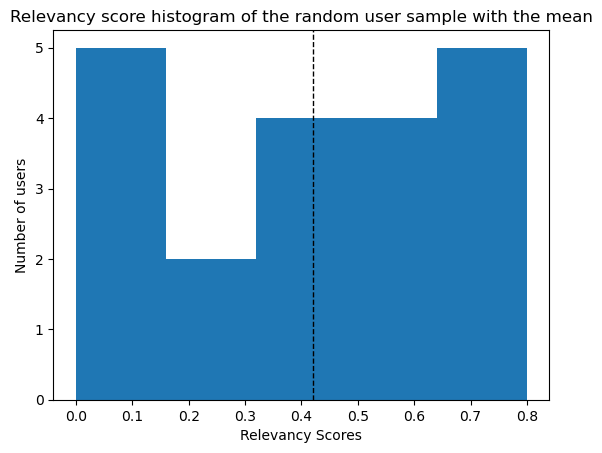

In [24]:
relevancy_scores.plot.hist(bins=5)
plt.axvline(relevancy_scores.mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Relevancy Scores')
plt.ylabel('Number of users')
plt.title('Relevancy score histogram of the random user sample with the mean')
plt.show()

The relevancy scores show that on an average 2 out of 5 recommended recipes are relevant for each user in the random sample.

## 9. Conclusions

- Main recommendation engine uses the following types:
    - Simple: Top-n rated recipes by all users
    - Content: Top-n closest recipes to a given recipe
    - Hybrid: Top-n closest recipes reviewed by users most similar to a given user's recipe history
- In lieu of established performance metrics, model performance was manually assessed to find 2/5 recommendations relevant for each user in a random sample of 20.
- To improve recommender performance, more features could be extracted from the data such as recipe type (appetizer, entrée, etc), and the ingredients can be analyzed further.
- Ultimately, the data dictates the model performance therefore better datasets, particularly one that provides more metadata about the users would be the best way to improve performance.